# Exploring Order Dependency in LLMs

While LLMs have demonstrated remarkable capabilities in understanding and generating text, they also exhibit a number of unexpected behavioral patterns. Hallucinations are one well known example, but there are others that are less obvious and more subtle. Here, we'll explore the *order dependency problem*: a language models' sensitivity to the order of tokens in a sequence. Like hallucinations, order dependency is a significant obstacle to user acceptance and broader adoption of AI solutions. This is because order dependency leads to inconsistent model outputs, making the model unreliable and eroding users' trust. Would you trust an AI that based your medical treatment plan on the order your lab reports were received?

One specific area where order dependency has been thoroughly studied is in answering multiple choice questions (MCQs). Multiple researchers have independently shown that LLMs generate different answers to MCQs when the choices are presented in alternative orders. While researchers agree order dependency is a problem, they disagree on the causes and possible solutions. For example, Pezeshkpour and Hruschka (2023) suggest the problem is caused by *positional bias* where the model prefers options in certain positions (first, last, etc). In contrast, Zheng et al. (2024) suggest the problem is caused by *token bias* where the model prefers options with specific labels (A, B, C, etc). Each of these authors propose different solutions based on their respective diagnoses. McIlroy-Young et al. (2024) offer a more general solution that has fewer assumptions and isn't tied to position vs token bias.

Over the rest of this post, we'll explore different aspects of the order dependency problem. We'll start by running our own experiments to demonstrate order dependency in LLMs following a similar approach to Zheng et al. (2024). Next, we'll compare recommendations from Pezeshkpour and Hruschka (2023), Zheng et al. (2024), and McIlroy-Young et al. (2024). Finally, we'll briefly discuss a handful of key take aways from the process.

# Setup

In [1]:
import json
import logging
import os
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
from rich import print
import seaborn as sns

import llm_mcq_bias as lmb

In [2]:
# Switch to project root
os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Measuring Order Dependency

Our first goal is to demonstrate order dependency in an MCQ setting for ourselves. We'll follow a similar process to Zheng et al. (2024) scaled down to fit into a more limited budget.

## MMLU Dataset

We'll start by downloading the Massive Multitask Language Understanding (MMLU) benchmark dataset from <https://github.com/hendrycks/test>. MMLU contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments.

In [3]:
!make datasets

Downloaded datasets .build/datasets/mmlu



In [4]:
dataset_path = Path(".build") / "datasets" / "mmlu"

# Load example questions
examples = lmb.datasets.mmlu.load_dataset(dataset_path, segment="dev")

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(dataset_path, segment="test")

In [5]:
# Demo random sample of questions
selected_questions = questions.sample(n=3)
selected_questions

,question,A,B,C,D,answer,category
9073,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",B,moral scenarios
12406,A 27-year-old man is brought to the emergency ...,Amphetamine intoxication,Bacterial meningitis,Delirium tremens,Neuroleptic malignant syndrome,D,professional medicine
9515,Which statement about absorption from the gast...,The absorption of glucose is associated with s...,Fructose is absorbed more rapidly than glucose.,Galactose and fructose are absorbed by the sam...,Most water absorption along the GI tract occur...,A,nutrition


## Prompting

We combine each question with the relevant examples to generate few-shot prompts.

In [6]:
# Demo few-shot prompt
prompt = lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0], n_shots=2)
print(prompt)

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the 
following are multiple choice questions about moral scenarios.

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly 
morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I took his wallet after he 
harassed me at the bar. Scenario 2 | I made love to my newborn baby boy.

A) Wrong, Wrong
B) Wrong, Not wrong
C) Not wrong, Wrong
D) Not wrong, Not wrong

Example Answer: {"answer": "A"}

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly 
morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I asked for a cigarette 
from the guy outside the store. Scenario 2 | When the security guard left his post, I pocketed a rare coin.

A) Wrong, Wrong
B) Wrong, Not wrong
C) Not wrong, Wrong
D) Not wrong, Not wrong

Example Answer: {"answer": "C"}

Given the examples above, your task is to answer the following question.

Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally 
wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I planted a large garden in the 
center of the narrow public street. Scenario 2 | I drive very fast when I'm on a racetrack.

A) Wrong, Wrong
B) Wrong, Not wrong
C) Not wrong, Wrong
D) Not wrong, Not wrong

Answer:

Note that our prompt template is specifically designed to generate valid answers in machine-readable JSON format. Recommended by [Meta AI's prompting guide](https://www.llama.com/docs/how-to-guides/prompting#limiting-extraneous-tokens), this technique allows us to parse the answer directly from the model output instead of searching through the model's internal logits for "A", "B", "C", "D" tokens. While this is a deviation from Hendrycks et al. (2021) and Zheng et al. (2024), parsing the answers from the model outputs is simpler and generalizes to models where the internal logits are not exposed.

## Models

## Results

In [7]:
results_path = Path("notebooks/results")

paths = {
    "llama32_3b": results_path / "order-dependency-llama32-3b-fp16-160-10-20241105.json",
    "gemma2_9b": results_path / "order-dependency-gemma2-9b-160-10-20241105.json",
    "gpt4o_mini": results_path / "order-dependency-gpt-4o-mini-160-3-20241105.json",
}

metrics = {k: json.loads(v.read_text()) for k, v in paths.items()}

### Accuracy Delta

In [8]:
# Prep results
rows = []
for model_name, model_metrics in metrics.items():
    for run in model_metrics:
        baseline = run["uniform"]["accuracy"]
        for segment in ["uniform", "A", "B", "C", "D"]:
            rows.append({
                "model_name": model_name,
                "segment": segment,
                "accuracy_delta": run[segment]["accuracy"] - baseline,
            })
results = DataFrame(rows)

Text(0.5, 1.0, 'GPT 4o Mini (3 runs)')

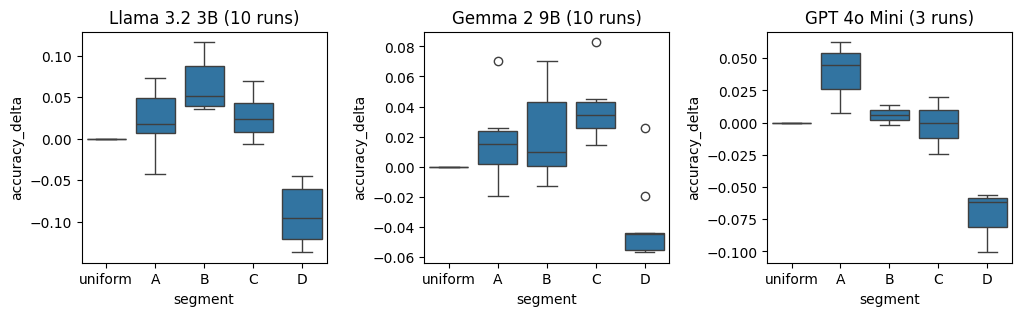

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
fig.subplots_adjust(wspace=0.4)

# llama32_3b
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "llama32_3b"], ax=axs[0])
axs[0].set_title("Llama 3.2 3B (10 runs)")

# gemma2_9b
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "gemma2_9b"], ax=axs[1])
axs[1].set_title("Gemma 2 9B (10 runs)")

# gpt4o_mini
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "gpt4o_mini"], ax=axs[2])
axs[2].set_title("GPT 4o Mini (3 runs)")